Saved 114 peaks → C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\simulation.peak_positions.csv
          table  H  K   L    phi_deg   intensity   x_pix   y_pix
0   hits_peak_1 -1  0  14 -23.740585   11.460113  1085.0   747.0
1   hits_peak_1 -1  0  14  23.740896   11.459864  1821.0   747.0
2  hits_peak_10 -1  0  11 -25.435621  105.180172  1069.0  1025.0
3  hits_peak_10 -1  0  11  25.435940  105.185264  1838.0  1025.0
4  hits_peak_11 -1 -1   9 -45.092678    8.942016   646.0  1057.0


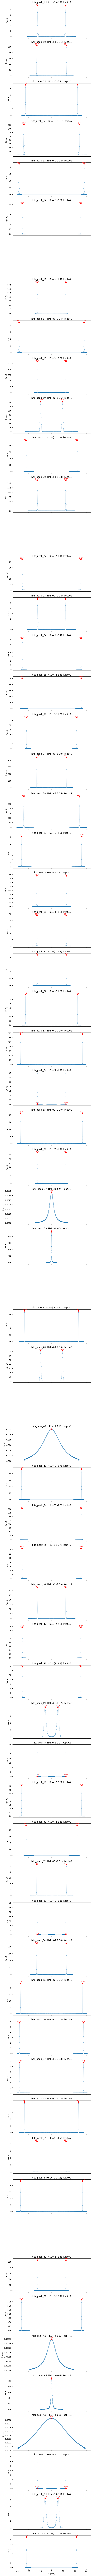

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks, savgol_filter

"""
plot_peak_positions_dedup.py
────────────────────────────
Detect local maxima in each `hits_peak_*` array inside *simulation.npz*.
Rules enforced per reflection:
    • If H = K = 0  → keep **exactly one** peak (strongest).
    • Otherwise     → keep **exactly two** peaks (two strongest, distinct).

A light Savitzky–Golay smoothing removes pixel‑scale noise before
`find_peaks` is called.

Output:  `<simulation>.peak_positions.csv` with columns
    table,H,K,L,phi_deg,intensity,x_pix,y_pix
Optionally a quick‑look plot for every reflection.
"""

# ────────────────────────── User parameters ──────────────────────────
NPZ_PATH = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\simulation.npz")
CSV_OUT  = NPZ_PATH.with_suffix(".peak_positions.csv")
PLOT_REFLECTIONS = True

# Smoothing / peak‑finding   (tweak as needed) ------------------------
SMOOTH_WINDOW    = 11   # odd; auto‑shrinks if trace shorter
SMOOTH_POLYORDER = 2
PEAK_PROM_FRAC   = 0.05 # prominence threshold = frac × max(I)

# Duplicate removal -----------------------------------------------
DEDUPE_TOLERANCE = 0     # pixel units; 0 ⇒ exact same (x,y)

# ────────────────────────────────────────────────────────────────────
# 1) Load simulation file & discover hit tables
# ────────────────────────────────────────────────────────────────────
data = np.load(NPZ_PATH, allow_pickle=True)
peak_keys = sorted(k for k in data.files if k.startswith("hits_peak_"))
if not peak_keys:
    raise RuntimeError("No hit tables found in the file!")

records = []  # → list[dict] → DataFrame

# ────────────────────────────────────────────────────────────────────
# 2) Process each hits_peak_* table
# ────────────────────────────────────────────────────────────────────
for key in peak_keys:
    hits = data[key]  # (N,7): I,x_pix,y_pix,phi,H,K,L
    if hits.size == 0:
        continue

    I_raw  = hits[:, 0]
    phi    = np.rad2deg(hits[:, 3])  # rad → deg
    x_pix  = hits[:, 1]
    y_pix  = hits[:, 2]
    H, K, L = map(int, hits[0, 4:7])

    # Sort by φ so the trace is monotonic
    order  = np.argsort(phi)
    I_s    = I_raw[order]
    phi_s  = phi[order]
    x_s    = x_pix[order]
    y_s    = y_pix[order]

    # Smoothing (skip if too few points)
    win = min(SMOOTH_WINDOW, len(I_s) - (len(I_s) + 1) % 2)
    I_smooth = savgol_filter(I_s, window_length=win, polyorder=SMOOTH_POLYORDER) if win >= 5 else I_s

    # Peak detection
    peak_idx, _ = find_peaks(I_smooth, prominence=PEAK_PROM_FRAC * I_smooth.max())
    if len(peak_idx) == 0:
        continue  # nothing to store

    # Build DF of candidates sorted by intensity desc
    cand = pd.DataFrame({
        "idx": peak_idx,
        "intensity": I_s[peak_idx],      # original intensity
        "phi_deg": phi_s[peak_idx],
        "x_pix": x_s[peak_idx].round().astype(int),
        "y_pix": y_s[peak_idx].round().astype(int)
    }).sort_values("intensity", ascending=False)

    # Deduplicate by detector pixel if requested
    if DEDUPE_TOLERANCE > 0:
        cand["x_bin"] = (cand["x_pix"] / DEDUPE_TOLERANCE).round().astype(int)
        cand["y_bin"] = (cand["y_pix"] / DEDUPE_TOLERANCE).round().astype(int)
        cand = cand.drop_duplicates(subset=["x_bin", "y_bin"]).drop(columns=["x_bin", "y_bin"])
    else:
        cand = cand.drop_duplicates(subset=["x_pix", "y_pix"])

    # Enforce required count (1 for HK=0, else 2)
    need = 1 if (H == 0 and K == 0) else 2
    if len(cand) < need:
        print(f"[warn] {key} HKL=({H} {K} {L}) only {len(cand)} peak(s) found, expected {need}")
    cand = cand.head(need)

    # Record
    for _, row in cand.iterrows():
        records.append({
            "table": key,
            "H": H, "K": K, "L": L,
            "phi_deg": row.phi_deg,
            "intensity": row.intensity,
            "x_pix": row.x_pix,
            "y_pix": row.y_pix
        })

# ────────────────────────────────────────────────────────────────────
# 3) Build master DataFrame & save CSV
# ────────────────────────────────────────────────────────────────────
if not records:
    raise RuntimeError("No peaks recorded – relax thresholds or check inputs.")

df = pd.DataFrame.from_records(records)

df = df.sort_values(["table", "phi_deg"]).reset_index(drop=True)

df.to_csv(CSV_OUT, index=False)
print(f"Saved {len(df)} peaks → {CSV_OUT}")
print(df.head())

# ────────────────────────────────────────────────────────────────────
# 4) Optional – sanity‑check plot per reflection
# ────────────────────────────────────────────────────────────────────
if PLOT_REFLECTIONS:
    n_ref = len(peak_keys)
    fig, axes = plt.subplots(n_ref, 1, figsize=(7, 3 * n_ref), sharex=True, tight_layout=True)
    if n_ref == 1:
        axes = [axes]

    for ax, key in zip(axes, peak_keys):
        hits = data[key]
        if hits.size == 0:
            ax.set_visible(False)
            continue

        I_raw = hits[:, 0]
        phi    = np.rad2deg(hits[:, 3])
        H, K, L = map(int, hits[0, 4:7])

        ax.scatter(phi, I_raw, s=8, alpha=0.4)
        ax.plot(*zip(*sorted(zip(phi, I_raw))), lw=0.5, alpha=0.3)

        sel = df["table"] == key
        ax.scatter(df.loc[sel, "phi_deg"], df.loc[sel, "intensity"], c="red", s=40, zorder=3)
        for _, row in df[sel].iterrows():
            ax.annotate(f"{row['phi_deg']:.1f}°", (row['phi_deg'], row['intensity']),
                        textcoords="offset points", xytext=(0, 5), ha="center", fontsize=8, color="red")

        ax.set_ylabel("I (a.u.)")
        ax.set_title(f"{key}  HKL=({H} {K} {L})  kept={sel.sum()}")

    axes[-1].set_xlabel("φ (deg)")
    plt.show()


[info] removed 54 overlapping peak(s) with identical detector pixel
[saved] C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\peak_map.png


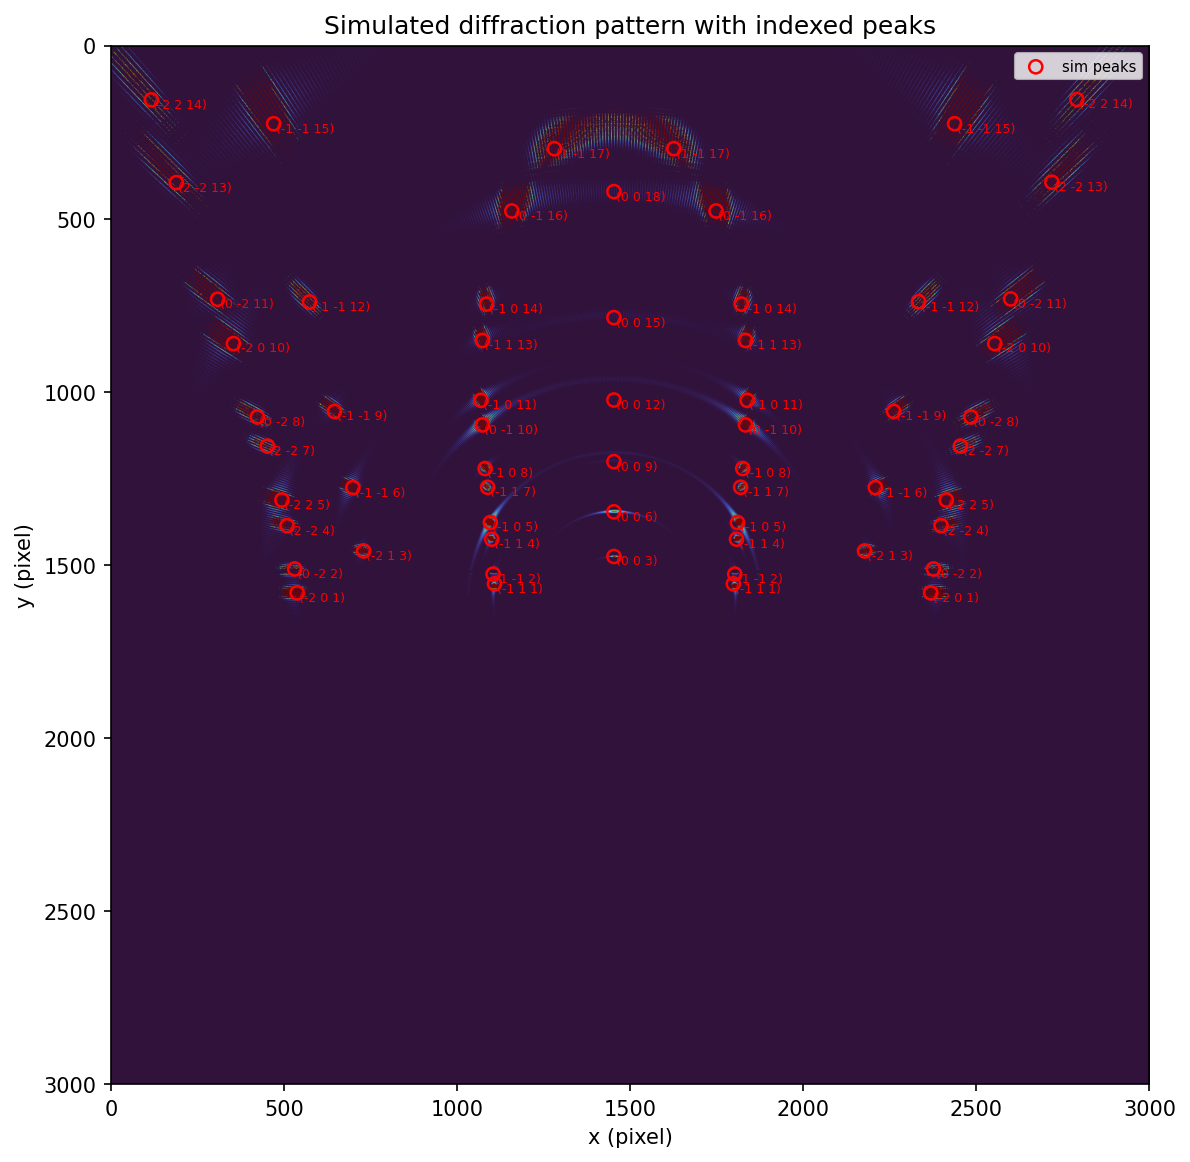

In [44]:
#!/usr/bin/env python3
"""
plot_peak_positions.py (dedup)
─────────────────────────────
Visualise simulated diffraction image and overlay indexed Bragg peaks.
If two (or more) HKL rows share the **same detector pixel**, only the
first encountered is displayed (duplicates removed on `(x_pix, y_pix)`).

Inputs
------
1) simulation.npz  – 3000×3000 image (field "image")
2) simulation.peak_positions.csv – columns x_pix,y_pix,H,K,L[,intensity,…]

Edit the three paths below, then run:
    python plot_peak_positions.py
"""

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── configure paths ─────────────────────────────────────────────────
IMG_PATH = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\simulation.npz")
CSV_PATH = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\simulation.peak_positions.csv")
FIG_OUT  = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\peak_map.png")
DET_SIZE = 3000  # detector pixels

# ── 1) load detector image ─────────────────────────────────────────
with np.load(IMG_PATH, allow_pickle=True) as npz:
    img = npz["image"].astype(float)
if img.shape != (DET_SIZE, DET_SIZE):
    raise ValueError(f"Expected image {DET_SIZE}×{DET_SIZE}, got {img.shape}")

vmin, vmax = 0.0, np.percentile(img, 99.5)

# ── 2) load peak list & drop duplicate pixels ───────────────────────
df = pd.read_csv(CSV_PATH)
need_cols = {"x_pix", "y_pix", "H", "K", "L"}
if not need_cols.issubset(df.columns):
    raise KeyError(f"CSV must contain {sorted(need_cols)}")
if df.empty:
    raise RuntimeError("Peak list is empty!")

# keep first occurrence of each detector pixel
before = len(df)
df = df.drop_duplicates(subset=["x_pix", "y_pix"])
after = len(df)
if before - after:
    print(f"[info] removed {before-after} overlapping peak(s) with identical detector pixel")

# ── 3) plot ────────────────────────────────────────────────────────
plt.figure(figsize=(8, 8), dpi=150)
plt.imshow(img, cmap="turbo", vmin=vmin, vmax=vmax, origin="upper",
           extent=[0, DET_SIZE, DET_SIZE, 0])

plt.scatter(df.x_pix, df.y_pix, s=40, facecolors='none', edgecolors='red', lw=1.2,
            label="sim peaks")

for _, r in df.iterrows():
    plt.text(r.x_pix + 6, r.y_pix - 6, f"({int(r.H)} {int(r.K)} {int(r.L)})",
             color="red", fontsize=6, ha='left', va='top')

plt.title("Simulated diffraction pattern with indexed peaks")
plt.xlabel("x (pixel)")
plt.ylabel("y (pixel)")
plt.xlim(0, DET_SIZE)
plt.ylim(DET_SIZE, 0)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()

plt.savefig(FIG_OUT, dpi=300)
print(f"[saved] {FIG_OUT}")
plt.show()

[saved] C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\peaks_and_blobs_shared.png


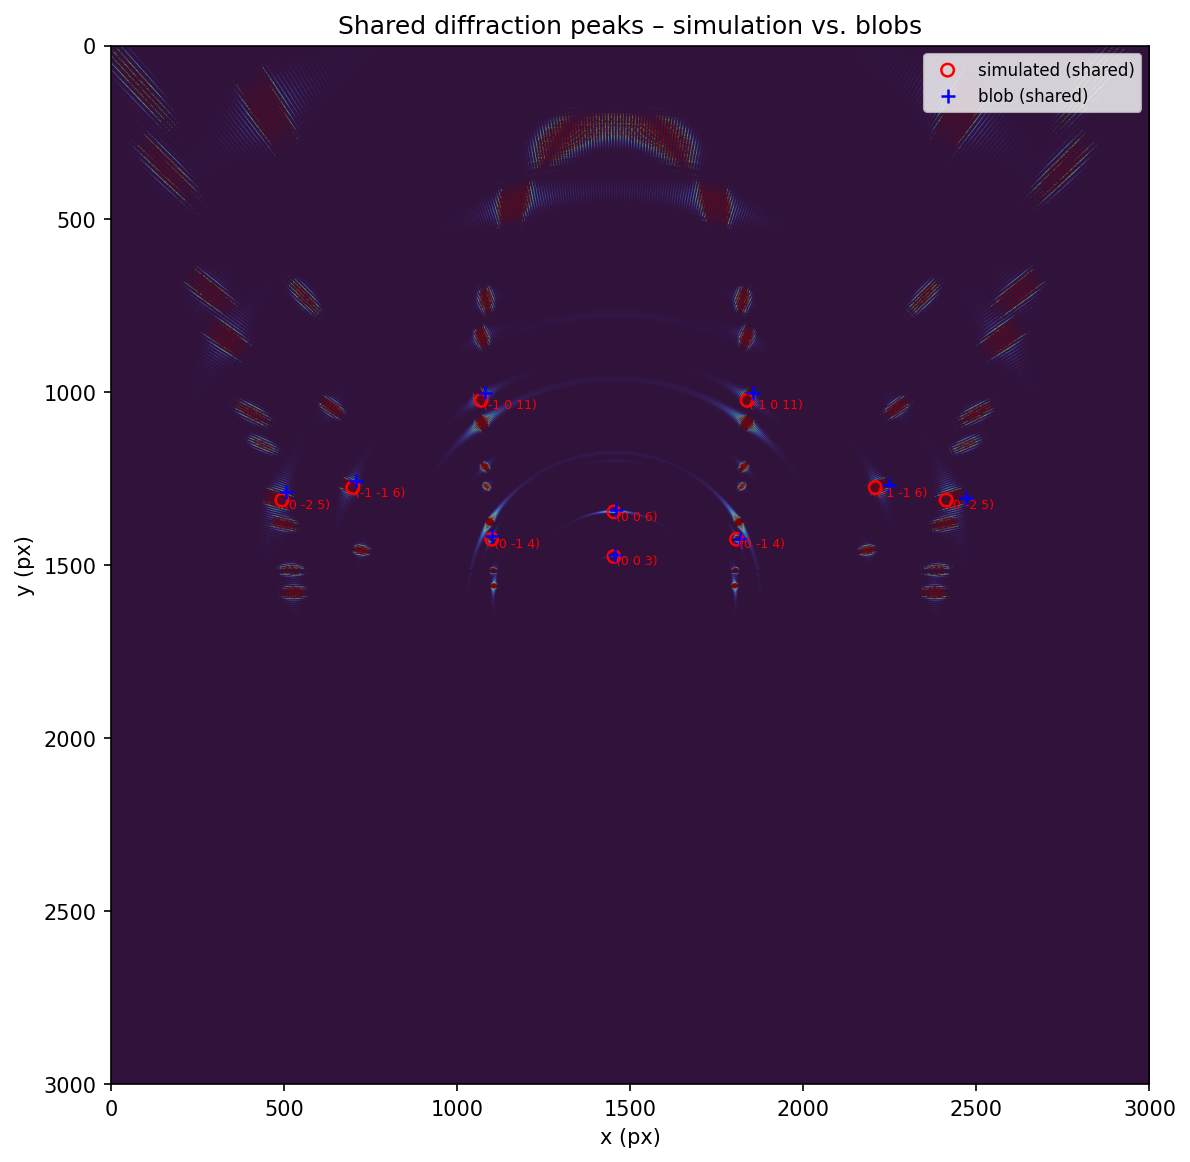

In [46]:
#!/usr/bin/env python3
"""
plot_peaks_and_blobs_shared.py
──────────────────────────────
Show **only those reflections that appear in both** the simulation peak
list and the blob‑detection list (matching on |H|,|K|,|L|).

* simulation.npz → detector image (3000×3000, field "image")
* simulation.peak_positions.csv → simulated peaks (x_pix,y_pix,H,K,L)
* blobs.npy → array of dicts {'label':'h,k,l', 'x':.., 'y':.., ...}

The plot overlays:
    ■ red squares   – simulation peak positions
    ✚ blue pluses   – blob positions
—and labels the shared HKL next to the red square.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ── 1) configure paths ──────────────────────────────────────────────
IMG_PATH     = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\simulation.npz")
SIM_CSV_PATH = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\ra_sim\tests\simulation.peak_positions.csv")
BLOB_PATH    = Path(r"C:\Users\Kenpo\OneDrive\Documents\GitHub\blobs.npy")

FIG_OUT  = IMG_PATH.parent / "peaks_and_blobs_shared.png"
DET_SIZE = 3000  # detector size in pixels

# ── 2) load detector image ──────────────────────────────────────────
with np.load(IMG_PATH, allow_pickle=True) as npz:
    img = npz["image"].astype(float)
if img.shape != (DET_SIZE, DET_SIZE):
    raise ValueError(f"Expected image {DET_SIZE}×{DET_SIZE}, got {img.shape}")

vmin, vmax = 0.0, np.percentile(img, 99.5)

# ── 3) load simulation peaks CSV ────────────────────────────────────
sim_df = pd.read_csv(SIM_CSV_PATH)
need_cols = {"x_pix", "y_pix", "H", "K", "L"}
if not need_cols.issubset(sim_df.columns):
    raise KeyError(f"{SIM_CSV_PATH.name} must have columns {sorted(need_cols)}")

# ── 4) load blobs.npy and convert to DataFrame ──────────────────────
blobs_raw = np.load(BLOB_PATH, allow_pickle=True)
blob_df = pd.DataFrame([
    {
        "H": int(t[0]),
        "K": int(t[1]),
        "L": int(t[2]),
        "x_pix": int(round(b["x"])),
        "y_pix": int(round(b["y"])),
    }
    for b in blobs_raw
    for t in [list(map(int, b["label"].split(",")))]
])

# ── 5) find shared reflections (match by absolute HKL) ─────────────
for df_ in (sim_df, blob_df):
    df_["|H|"] = df_["H"].abs()
    df_["|K|"] = df_["K"].abs()
    df_["|L|"] = df_["L"].abs()

sim_keys  = set(zip(sim_df["|H|"], sim_df["|K|"], sim_df["|L|"]))
blob_keys = set(zip(blob_df["|H|"], blob_df["|K|"], blob_df["|L|"]))
shared_keys = sim_keys & blob_keys
if not shared_keys:
    raise RuntimeError("No matching reflections found between simulation and blobs.")

sim_shared  = sim_df[sim_df[["|H|", "|K|", "|L|"]].apply(tuple, axis=1).isin(shared_keys)]
blob_shared = blob_df[blob_df[["|H|", "|K|", "|L|"]].apply(tuple, axis=1).isin(shared_keys)]

# ── 6) plot ─────────────────────────────────────────────────────────
plt.figure(figsize=(8, 8), dpi=150)
plt.imshow(img, cmap="turbo", vmin=vmin, vmax=vmax, origin="upper")

# Simulation peaks (red squares + HKL)
plt.scatter(sim_shared.x_pix, sim_shared.y_pix,
            s=36, facecolors="none", edgecolors="red", lw=1.2,
            label="simulated (shared)")
for _, r in sim_shared.iterrows():
    plt.text(r.x_pix + 6, r.y_pix - 6,
             f"({r.H} {r.K} {r.L})", color="red", fontsize=6,
             ha="left", va="top")

# Blob detections (blue plus)
plt.scatter(blob_shared.x_pix, blob_shared.y_pix,
            marker="+", s=40, lw=1.2, color="blue", label="blob (shared)")

plt.title("Shared diffraction peaks – simulation vs. blobs")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.xlim(0, DET_SIZE)
plt.ylim(DET_SIZE, 0)
plt.gca().set_aspect("equal", adjustable="box")
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()

plt.savefig(FIG_OUT, dpi=300)
print(f"[saved] {FIG_OUT}")
plt.show()


In [ ]:
# ── 5b) χ² between simulation and blob coordinates ────────────────
# build a unique key on |H|,|K|,|L|
for df in (sim_shared, blob_shared):
    df["key"] = list(zip(df["|H|"], df["|K|"], df["|L|"]))

# merge – one row per shared reflection
merged = pd.merge(
    sim_shared[["key", "x_pix", "y_pix"]].rename(
        columns={"x_pix": "x_sim", "y_pix": "y_sim"}
    ),
    blob_shared[["key", "x_pix", "y_pix"]].rename(
        columns={"x_pix": "x_blob", "y_pix": "y_blob"}
    ),
    on="key",
)

# optional: supply empirical localisation error (σ) in px
# If you have a per-peak uncertainty, add a column 'sigma' here.
sigma = 1.0  # px; change or replace by merged["sigma"] if available

dx = merged["x_sim"] - merged["x_blob"]
dy = merged["y_sim"] - merged["y_blob"]
chi2 = ((dx**2 + dy**2) / sigma**2).sum()          # total χ²
dof  = 2 * len(merged)                              # x & y per reflection
chi2_red = chi2 / dof                               # reduced χ²
rms_err = np.sqrt((dx**2 + dy**2).mean())           # RMS pixel error

print("──────── alignment quality ────────")
print(f"Shared reflections  : {len(merged)}")
print(f"χ² (σ={sigma:0.2f}px)        : {chi2:0.3f}")
print(f"χ²_red (dof={dof})     : {chi2_red:0.3f}")
print(f"RMS positional error  : {rms_err:0.3f} px")
print("────────────────────────────────────")


──────── alignment quality ────────
Shared reflections  : 18
χ² (σ=1.00px)        : 14405595.000
χ²_red (dof=36)     : 400155.417
RMS positional error  : 894.601 px
────────────────────────────────────


C:\Users\Kenpo\AppData\Local\Temp\ipykernel_44828\527446148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["key"] = list(zip(df["|H|"], df["|K|"], df["|L|"]))
C:\Users\Kenpo\AppData\Local\Temp\ipykernel_44828\527446148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["key"] = list(zip(df["|H|"], df["|K|"], df["|L|"]))


: 